# Introduction

In [54]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties

In [55]:
import pyspark
from pyspark.sql import SparkSession, functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
conf = pyspark.SparkConf()
settings = conf.getAll()

# Current Spark settings
for s in settings:
    print(s)
executor_memory = conf.get("spark.executor.memory")
executor_cores = conf.get("spark.executor.cores")
default_parallelism = conf.get("spark.default.parallelism")
print(f"Executor Memory: {executor_memory}")
print(f"Executor Cores: {executor_cores}")
print(f"Default Parallelism: {default_parallelism}")

# Set Spark Settings
conf = pyspark.SparkConf().setAll([
('spark.master', 'local[8]'),
('spark.app.name', 'MusicRecommender')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

('spark.app.submitTime', '1714713131213')
('spark.master', 'local[8]')
('spark.submit.pyFiles', '')
('spark.submit.deployMode', 'client')
('spark.app.name', 'MusicRecommender')
('spark.ui.showConsoleProgress', 'true')
Executor Memory: None
Executor Cores: None
Default Parallelism: None


In [57]:
# Config Variables
user = "hadoop"
HDFS_DATA = f"hdfs:///user/{user}/data"
partitions = 10

In [58]:
def load_file_from_hdfs(file_name):
    hdfs_path = f"{HDFS_DATA}/{file_name}"
    return spark.read.csv(hdfs_path, sep="\t", header=False, inferSchema=True)


train_files = [f"train/train_{i}.txt" for i in range(partitions)]
test_files = [f"test/test_{i}.txt" for i in range(partitions)]

train_data = None
test_data = None

for i, file in enumerate(train_files):
    train_partition_df = load_file_from_hdfs(file)
    train_partition_df = train_partition_df.withColumnsRenamed({"_c0": "user_id", "_c1": "song_id", "_c2": "rating"})
    # Add a partition column
    train_partition_df = train_partition_df.withColumn("partition_id", F.lit(i))
    # Comhbine all the partitions
    if train_data is None:
        train_data = train_partition_df
    else:
        train_data = train_data.union(train_partition_df)
    
for i, file in enumerate(test_files):
    test_partition_df = load_file_from_hdfs(file)
    test_partition_df = test_partition_df.withColumnsRenamed({"_c0": "user_id", "_c1": "song_id", "_c2": "rating"})
    # Add a partition column
    test_partition_df = test_partition_df.withColumn("partition_id", F.lit(i))
    # Comhbine all the partitions
    if test_data is None:
        test_data = test_partition_df
    else:
        test_data = test_data.union(test_partition_df)
        
total_dataset = train_data.union(test_data).cache()

    

In [59]:
def perform_eda(df):
    df.summary().show()
    
    ratings = df.count()
    print("Number of ratings: ", ratings)
    
    # # Duplicates and missing values
    # df = df.dropDuplicates()
    # df = df.dropna()
    # print("Number of ratings after removing duplicates and missing values: ", df.count())
    
    users = df.groupBy("user_id").count()
    print("Number of unique users: ", users.count())

    songs = df.groupBy("song_id").count()
    print("Number of unique songs: ", songs.count())

    return df

def plot_user_ratings_distribution(df, ax=None, partition_id=None):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # define a list of colors
    
    # Select rating column
    total_ratings = df.select("rating")
    print(total_ratings.summary().show())

    # user_rating_counts = df.groupBy("user_id").count()
    # user_rating_counts = user_rating_counts.withColumnRenamed("count", "rating_count")
    # user_rating_counts = user_rating_counts.groupBy("rating_count").count()
    # user_rating_counts = user_rating_counts.withColumnRenamed("count", "user_count")
    # user_rating_counts = user_rating_counts.sort("rating_count")
    
    user_rating_counts = user_rating_counts.toPandas()
    
    # Single plot
    # plt.figure(figsize=(10, 6))
    # sns.violinplot(data=user_rating_counts['rating_count'])
    # plt.title("Ratings Per User Distribution")
    # plt.xlabel("Users")
    # plt.ylabel("Ratings")
    # plt.show()
    
    # bar plot 
    # plt.figure(figsize=(10, 6))
    # sns.barplot(x="user_count", y="rating_count", data=user_rating_counts)
    # plt.title("Ratings Per User Distribution")
    # plt.xlabel("Users")
    # plt.ylabel("Ratings")
    
    # box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="rating_count", data=user_rating_counts)
    plt.title("Ratings Per User Distribution")
    plt.xlabel("Ratings")
    plt.ylabel("Users")
    
def plot_rating_distribution(df):
    plt.figure(figsize=(10, 6))
    ratings = df.groupBy("rating").count().sort("rating")
    colors = sns.color_palette("RdYlGn", 5)
    ratings = ratings.toPandas()
    sns.barplot(x="rating", y="count", data=ratings, palette=colors)
    plt.title("Rating Distribution")
    # show y axis with integer values with commas
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
    # Color from red to green
    plt.show()
    

# Training

In [14]:
# Show the first 5 rows of the train data
# train_data.show(5)

In [60]:
# Total dataset EDA 
# perform_eda(total_dataset)
# plot_rating_distribution(total_dataset)
perform_eda(total_dataset)


+-------+-----------------+------------------+------------------+-----------------+
|summary|          user_id|           song_id|            rating|     partition_id|
+-------+-----------------+------------------+------------------+-----------------+
|  count|        717872016|         717872016|         717872016|        717872016|
|   mean| 911836.872425172| 68273.60973778367| 3.164953702555248|4.064530349376371|
| stddev|525987.5660109359|39464.122210434245|1.6012943500215018|2.623926802093038|
|    min|                0|                 0|                 1|                0|
|    25%|           456056|             34381|                 1|                2|
|    50%|           911298|             68278|                 3|                4|
|    75%|          1366937|            102348|                 5|                6|
|    max|          1823178|            136735|                 5|                9|
+-------+-----------------+------------------+------------------+-----------

Number of ratings:  717872016


Number of unique users:  1823179


Number of unique songs:  136736


DataFrame[user_id: int, song_id: int, rating: int, partition_id: int]

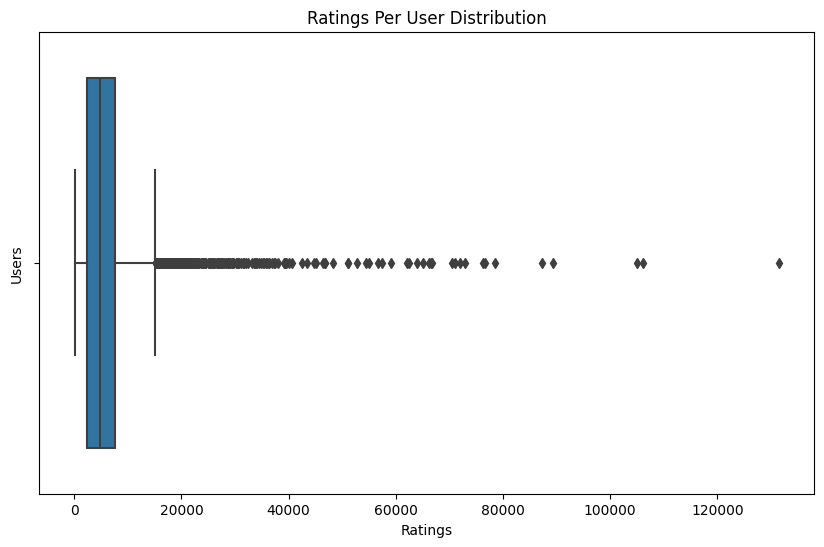

In [53]:
plot_user_ratings_distribution(total_dataset)

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=5, figsize=(20, 10))
fig.suptitle('Ratings per User Distribution', fontsize=16)
# plt.figure(figsize=(20, 15))

for i in range(10):
    row = i // 2
    col = i % 2
    print(f"Processing train data partition {i}")
    plot_user_ratings_distribution(train_data[i], ax=ax[col, row], partition_id=i)
    # plot_user_ratings_distribution(train_data[i], partition_id=i)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Test

In [ ]:
# for i in range(len(test_data)):
#     print(f"Processing test data partition {i}")
#     test_data[i] = perform_data_preprocessing(test_data[i])
#     # perform_eda(test_data[i])

In [ ]:
# spark.stop()